# Modèles de diffusion avec MedMNIST

L'objectif de ce notebook est d'adapter le tutoriel du livre de David Foster (disponible [ici](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/08_diffusion/01_ddm/ddm.ipynb)), mais en utilisant MedMNIST (en particulier pour commencer ChestMNIST).

# Paramètres globaux

Les paramètres globaux du modèle sont définis ici, permettant de configurer facilement la taille des images, le nombre de canaux, la taille du batch, etc.

In [1]:
IMAGE_SIZE = 64  # Taille des images (IMAGE_SIZE x IMAGE_SIZE)
BATCH_SIZE = 8
NUM_CHANNELS = 1  # Nombre de canaux (1 pour grayscale, 3 pour RGB)
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 10

# Chargement du jeu de données

Nous allons charger le jeu de données MedMNIST pour l'utiliser dans notre tutoriel. En particulier, nous prendrons les radiographies thoraciques (ChestMNIST).

In [2]:
from medmnist import ChestMNIST

train_dataset = ChestMNIST(split="train", download=True, size=IMAGE_SIZE)
images, labels = train_dataset.imgs, train_dataset.labels

print(f"Nombre d'images dans le dataset d'entraînement : {len(images)}")

Nombre d'images dans le dataset d'entraînement : 78468


Maintenant que nous avons les images, nous allons les prétraiter pour les rendre compatibles avec notre modèle de diffusion. Nous allons commencer par les transformer en tenseurs avec tensorflow.

In [3]:
import tensorflow as tf

tf_dataset = tf.data.Dataset.from_tensor_slices(images)
print(f"Taille du dataset TensorFlow : {len(tf_dataset)}")
print(f"Taille des éléments du dataset : {tf_dataset.element_spec}")

2025-10-01 17:04:05.029962: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Taille du dataset TensorFlow : 78468
Taille des éléments du dataset : TensorSpec(shape=(64, 64), dtype=tf.uint8, name=None)


I0000 00:00:1759331046.657368 3343221 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1082 MB memory:  -> device: 0, name: Quadro T1000, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-10-01 17:04:06.661897: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 321404928 exceeds 10% of free system memory.
2025-10-01 17:04:06.842629: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 321404928 exceeds 10% of free system memory.


Regardons à quoi ressemblent les images du dataset ChestMNIST.

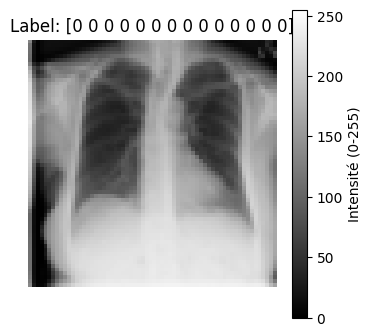

In [4]:
import matplotlib.pyplot as plt

# Prendre la première image et son label
img = images[0]   # array (28,28)
label = labels[0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap="gray", vmin=0, vmax=255)  # niveaux de gris
plt.colorbar(label="Intensité (0-255)")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


On voit que les valeurs des images sont entre 0 et 255, on va donc les normaliser.

In [5]:
# Preprocess the data
def preprocess(img):
    # normalization
    img = tf.cast(img, "float32") / 255.0
    # add channel
    img = tf.expand_dims(img, -1)
    return img


tf_dataset = tf_dataset.map(lambda x: preprocess(x))
tf_dataset = tf_dataset.repeat(DATASET_REPETITIONS)
tf_dataset = tf_dataset.batch(BATCH_SIZE, drop_remainder=True)

x = next(iter(tf_dataset))
print("Input shape:", x.shape)

Input shape: (8, 64, 64, 1)


2025-10-01 17:04:07.108857: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 321404928 exceeds 10% of free system memory.


On peut maintenant faire comme dans le tutoriel de David Foster, en commençant par utiliser ses fonctions utilitaires de visualisation.

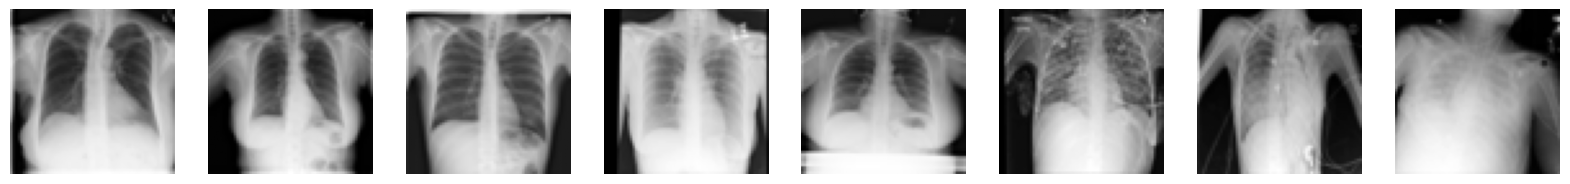

In [6]:
from utils import display, sample_batch
train_sample = sample_batch(tf_dataset)
display(train_sample, n=min(BATCH_SIZE, 10), cmap="gray")

## Entraînement du modèle de diffusion

Nous allons reprendre les classes et fonctions du tutoriel de David Foster, puis les adapter pour notre dataset.

In [7]:
from diffusion_models import DiffusionModel

diffusion_model = DiffusionModel(
    image_size=IMAGE_SIZE,
    num_channels=NUM_CHANNELS,
    noise_embedding_size=NOISE_EMBEDDING_SIZE,
    batch_size=BATCH_SIZE,
    ema=EMA
)

Le code a été adapté de telle manière qu'il n'y a plus qu'à lancer l'entraînement du modèle avec une seule ligne de code.

Epoch 1/10


2025-10-01 17:05:45.841588: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-01 17:05:54.912932: I external/local_xla/xla/service/service.cc:163] XLA service 0x73fff8002d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-01 17:05:54.912944: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro T1000, Compute Capability 7.5
2025-10-01 17:05:55.197632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-01 17:05:55.640479: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:62] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
2025-10-01 17:05:56.640090: I external/local_xla/xla/s

    3/49042 ━━━━━━━━━━━━━━━━━━━━ 43:21 53ms/step - n_loss: 1.0026  

I0000 00:00:1759331173.898959 3343583 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49042/49042 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - n_loss: 0.0424
Saved to ./output/generated_img_000.png


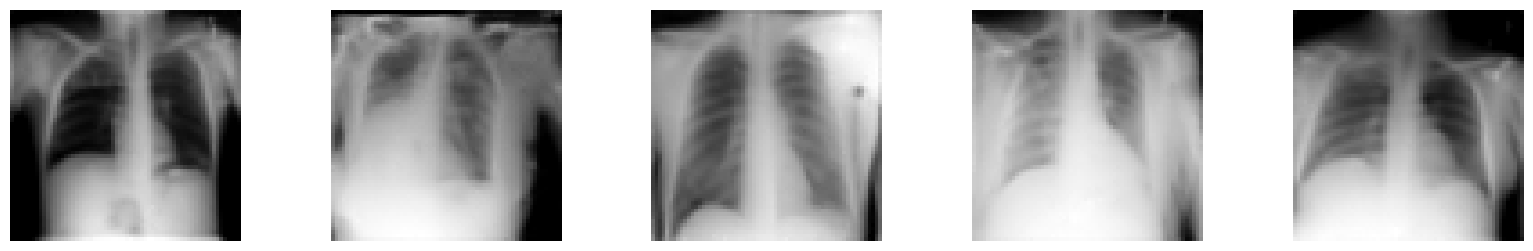

49042/49042 ━━━━━━━━━━━━━━━━━━━━ 2568s 52ms/step - n_loss: 0.0289
Epoch 2/10
49042/49042 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - n_loss: 0.0239
Saved to ./output/generated_img_001.png


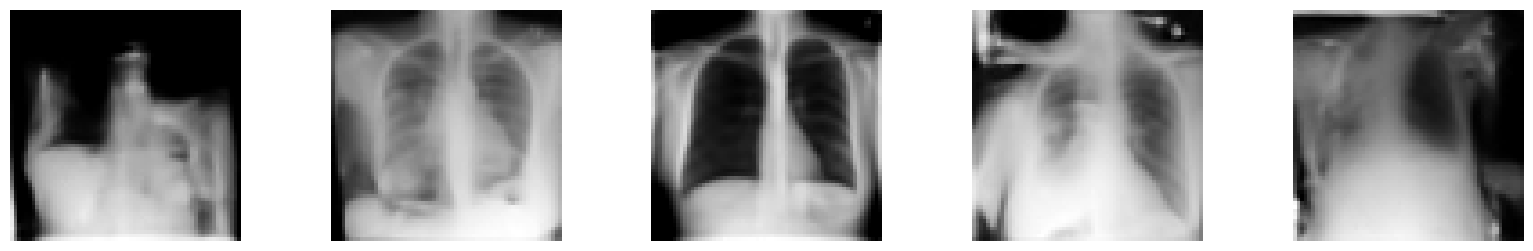

49042/49042 ━━━━━━━━━━━━━━━━━━━━ 2797s 57ms/step - n_loss: 0.0236
Epoch 3/10
49042/49042 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - n_loss: 0.0229
Saved to ./output/generated_img_002.png


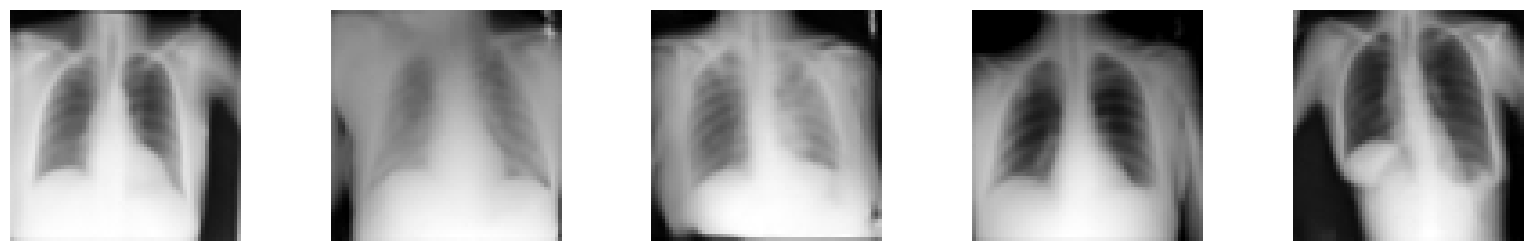

49042/49042 ━━━━━━━━━━━━━━━━━━━━ 3134s 64ms/step - n_loss: 0.0227
Epoch 4/10
49042/49042 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - n_loss: 0.0225
Saved to ./output/generated_img_003.png


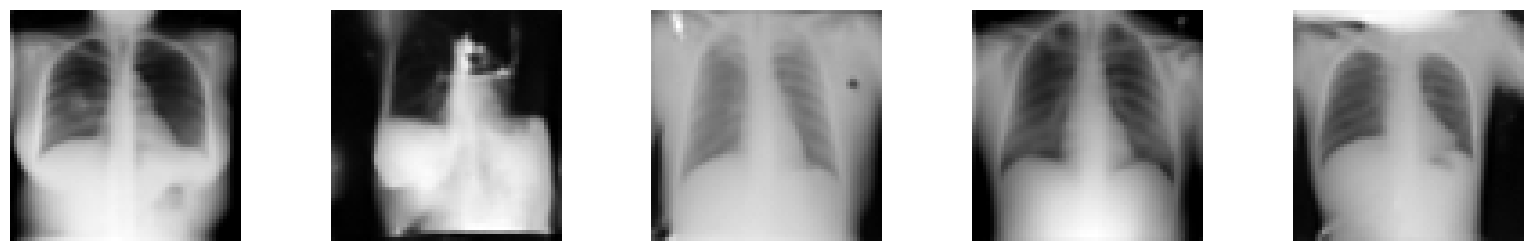

49042/49042 ━━━━━━━━━━━━━━━━━━━━ 3438s 70ms/step - n_loss: 0.0224
Epoch 5/10
49042/49042 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - n_loss: 0.0221
Saved to ./output/generated_img_004.png


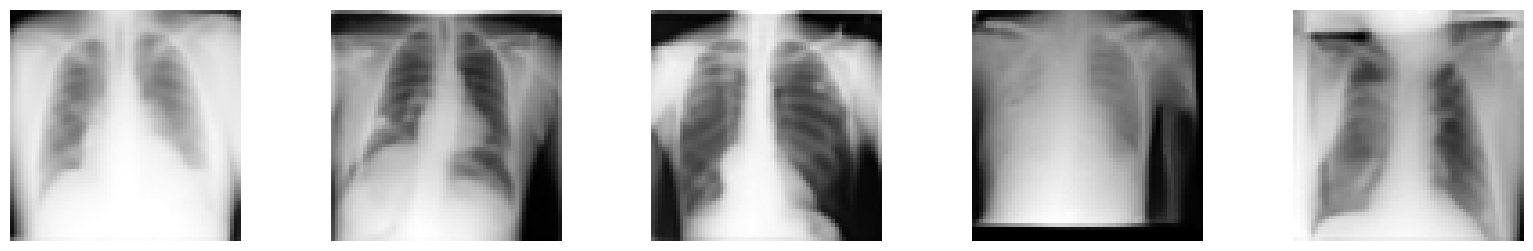

49042/49042 ━━━━━━━━━━━━━━━━━━━━ 3695s 75ms/step - n_loss: 0.0221
Epoch 6/10
49042/49042 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - n_loss: 0.0220
Saved to ./output/generated_img_005.png


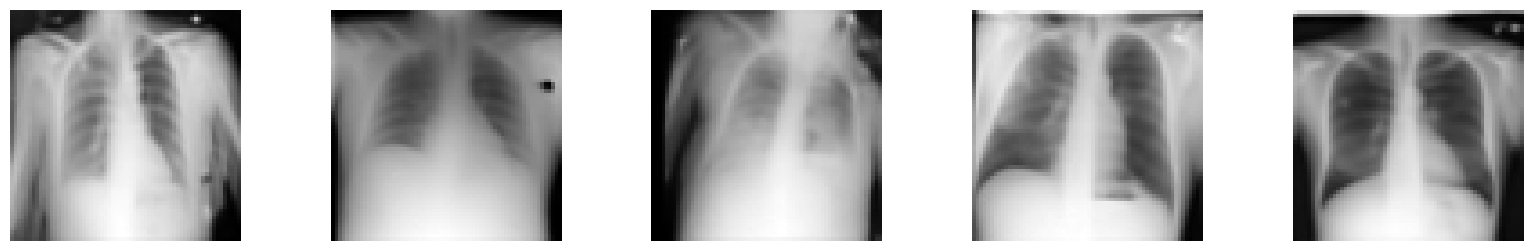

49042/49042 ━━━━━━━━━━━━━━━━━━━━ 3967s 81ms/step - n_loss: 0.0219
Epoch 7/10
49042/49042 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - n_loss: 0.0217
Saved to ./output/generated_img_006.png


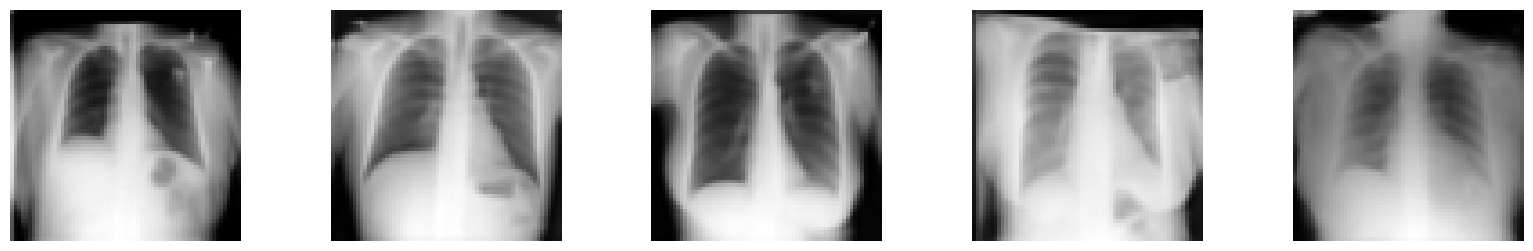

49042/49042 ━━━━━━━━━━━━━━━━━━━━ 4233s 86ms/step - n_loss: 0.0217
Epoch 8/10
49042/49042 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - n_loss: 0.0217
Saved to ./output/generated_img_007.png


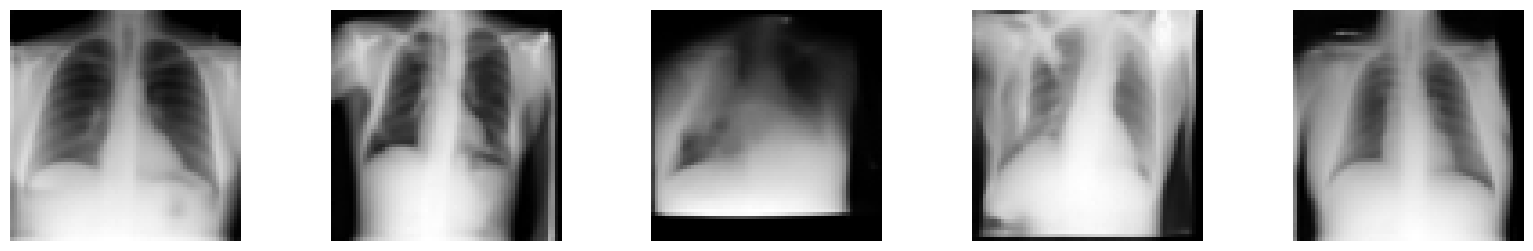

49042/49042 ━━━━━━━━━━━━━━━━━━━━ 4503s 92ms/step - n_loss: 0.0216
Epoch 9/10
49042/49042 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - n_loss: 0.0215
Saved to ./output/generated_img_008.png


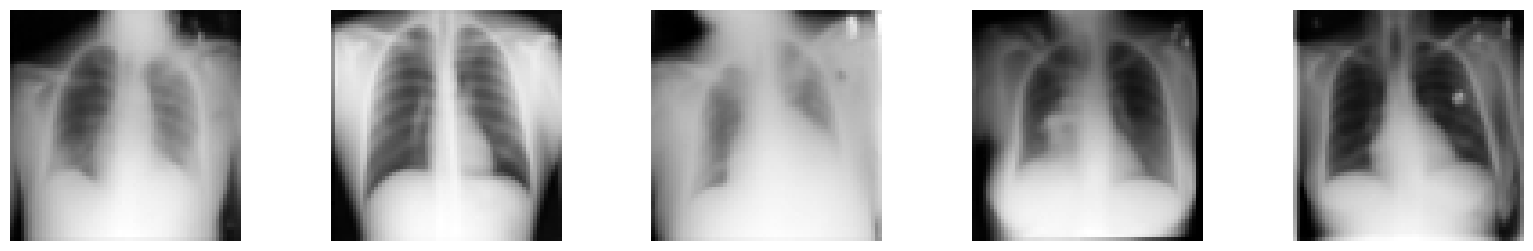

49042/49042 ━━━━━━━━━━━━━━━━━━━━ 4776s 97ms/step - n_loss: 0.0215
Epoch 10/10
49042/49042 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - n_loss: 0.0215
Saved to ./output/generated_img_009.png


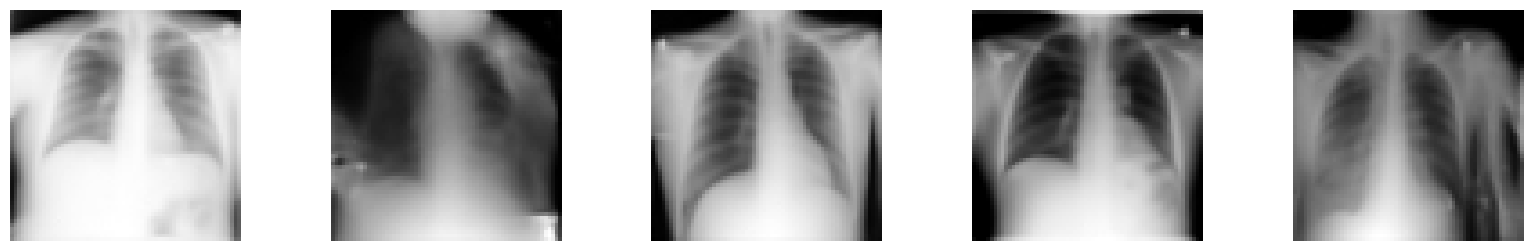

49042/49042 ━━━━━━━━━━━━━━━━━━━━ 5117s 104ms/step - n_loss: 0.0215


In [8]:
diffusion_model.train(tf_dataset, epochs=EPOCHS)